<img src="img/transit.png" width=300 height=50/>

## 🚌💨 Transit nerd incoming... Angelique Clara Hanzell

# Building Smarter, Inclusive Transit: A Data-Driven Approach to Ridership Insights, Route Optimization, and Equity


Some people write cover letters - I build projects. When I saw this opportunity, I knew I wanted to do more than just submit a resumé. Public transit has always fascinated me: the ebb and flow of commuters, the rhythm of a city moving as one. So, I decided to dive into the data, uncovering insights about the busiest stops, peak hours, and transit patterns.

This project isn’t just about numbers - it’s about understanding how people move and how transit can be improved. I hope it reflects not only my analytical skills but also my passion for making transportation smarter and more efficient.

Public transit is the backbone of Montreal’s urban mobility. By analyzing STM’s GTFS data, we can uncover insights to improve route efficiency, accessibility, and rider satisfaction. This project explores key questions such as:
- Which routes have the most frequent service?
- Are there gaps in accessibility for riders with mobility needs?
- How can we optimize schedules to better serve riders?

Let’s dive into the data! 🚋📊✨

### 1. Introduction
- Objective: Analyze STM’s GTFS data to uncover insights about transit routes, stops, and schedules, and provide recommendations for improving rider satisfaction and accessibility.
- Why This Matters: Public transit is essential for urban mobility, and data-driven insights can help make it more efficient, accessible, and user-friendly.

### 2. Loading and Exploring the GTFS Data

GTFS data typically includes tables like:
- `stops.txt`: Information about transit stops.
- `routes.txt`: Information about transit routes.
- `trips.txt`: Information about trips (e.g., route, schedule).
- `stop_times.txt`: Times for each stop on a trip.
- `calendar.txt`: Service schedules.

We’ll load and explore these tables.

In [46]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import zipfile
import os

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

stops = pd.read_csv('gtfs_stm/stops.txt')
routes = pd.read_csv('gtfs_stm/routes.txt')
trips = pd.read_csv('gtfs_stm/trips.txt')
stop_times = pd.read_csv('gtfs_stm/stop_times.txt')
calendar = pd.read_csv('gtfs_stm/calendar.txt')

# data overview
print("Stops DataFrame:")
print(stops.head())
print("\nRoutes DataFrame:")
print(routes.head())
print("\nTrips DataFrame:")
print(trips.head())
print("\nStop Times DataFrame:")
print(stop_times.head())
print("\nCalendar DataFrame:")
print(calendar.head())

stop_times['stop_id'] = stop_times['stop_id'].astype(str)
stops['stop_id'] = stops['stop_id'].astype(str)

# merge DataFrames to create a comprehensive view
merged_df = pd.merge(stop_times, trips, on='trip_id')
merged_df = pd.merge(merged_df, stops, on='stop_id')
merged_df = pd.merge(merged_df, routes, on='route_id')

# convert arrival_time to datetime
def convert_to_datetime(time_str):
    try:
        return datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # handle times that are greater than 24:00:00
        h, m, s = map(int, time_str.split(':'))
        h = h % 24
        return datetime.strptime(f'{h:02}:{m:02}:{s:02}', '%H:%M:%S').time()

merged_df['arrival_time'] = merged_df['arrival_time'].apply(convert_to_datetime)

Stops DataFrame:
        stop_id  stop_code          stop_name   stop_lat   stop_lon  \
0  STATION_M118      10118  STATION ANGRIGNON  45.446466 -73.603118   
1            43      10118  Station Angrignon  45.446466 -73.603118   
2         43-01      10118  Station Angrignon  45.446319 -73.603835   
3  STATION_M120      10120       STATION MONK  45.451158 -73.593242   
4            42      10120       Station Monk  45.451158 -73.593242   

                                            stop_url  location_type  \
0                                                NaN              1   
1  http://www.stm.info/fr/infos/reseaux/metro/ang...              0   
2                                                NaN              2   
3                                                NaN              1   
4    http://www.stm.info/fr/infos/reseaux/metro/monk              0   

  parent_station  wheelchair_boarding  
0            NaN                    1  
1   STATION_M118                    1  
2   STATI

In [47]:
merged_df.head()

trip_id arrival_time departure_time stop_id  stop_sequence  route_id  \
0  280272136     05:13:00       05:13:00   51096              1        93   
1  280272136     05:14:51       05:14:51   51140              2        93   
2  280272136     05:16:12       05:16:12   51199              3        93   
3  280272136     05:17:00       05:17:00   51227              4        93   
4  280272136     05:17:15       05:17:15   51266              5        93   

          service_id trip_headsign  direction_id  shape_id  ...  \
0  24N-H50N000A-80-A           Est           0.0  930083.0  ...   
1  24N-H50N000A-80-A           Est           0.0  930083.0  ...   
2  24N-H50N000A-80-A           Est           0.0  930083.0  ...   
3  24N-H50N000A-80-A           Est           0.0  930083.0  ...   
4  24N-H50N000A-80-A           Est           0.0  930083.0  ...   

   location_type parent_station wheelchair_boarding  agency_id  \
0              0            NaN                   1        STM   
1              0            NaN                   1        STM   
2              0            NaN                   1        STM   
3              0            NaN                   1        STM   
4              0            NaN                   1        STM   

  route_short_name  route_long_name  route_type  \
0               93       Jean-Talon           3   
1               93       Jean-Talon           3   
2               93       Jean-Talon           3   
3               93       Jean-Talon           3   
4               93       Jean-Talon           3   

                                  route_url  route_color route_text_color  
0  http://www.stm.info/fr/infos/reseaux/bus       009EE0           FFFFFF  
1  http://www.stm.info/fr/infos/reseaux/bus       009EE0           FFFFFF  
2  http://www.stm.info/fr/infos/reseaux/bus       009EE0           FFFFFF  
3  http://www.stm.info/fr/infos/reseaux/bus       009EE0           FFFFFF  
4  http://www.stm.info/fr/infos/reseaux/bus       009EE0           FFFFFF  

[5 rows x 28 columns]

### 3. Data Analysis

We’ll answer key questions about Montreal’s transit system:

#### Question 1: Which stop in Montreal is the busiest?
- Identifies the top 10 stops with the most arrivals.


Top 10 Busiest Stops:
stop_name
Station Angrignon           13912
Station Henri-Bourassa      12154
Station Lionel-Groulx       10981
Station Vendôme              9960
Station Berri-UQAM           8626
Station Honoré-Beaugrand     7453
Sherbrooke / Saint-Donat     6418
Newman / Dollard             6169
Newman / Angrignon           5724
Newman / Guy-Bouchard        5724
Name: count, dtype: int64


<ipython-input-48-3fc33062fc7c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=busiest_stops.values, y=busiest_stops.index, palette='viridis')


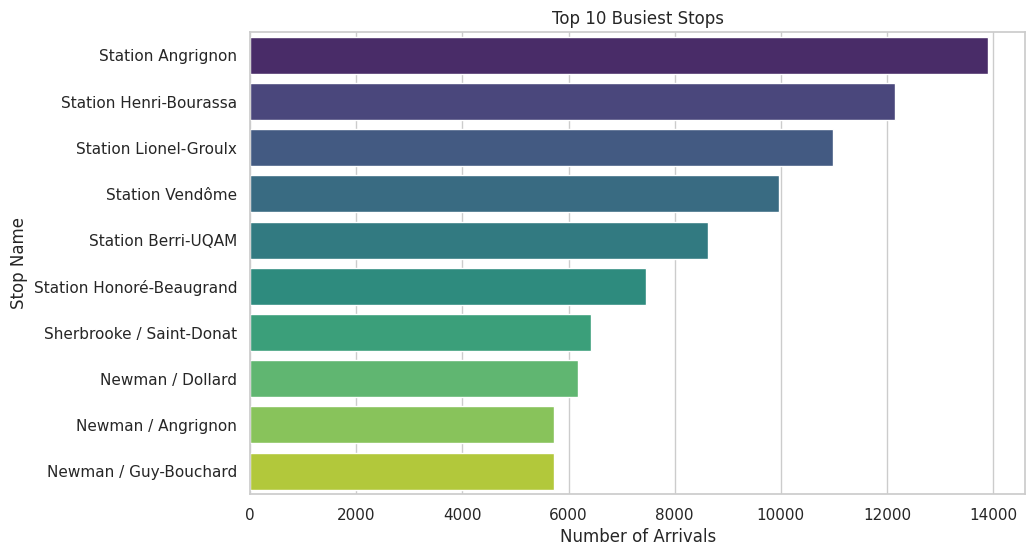

In [48]:
# busiest stop
busiest_stops = merged_df['stop_name'].value_counts().head(10)
print("\nTop 10 Busiest Stops:")
print(busiest_stops)

# visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=busiest_stops.values, y=busiest_stops.index, palette='viridis')
plt.title('Top 10 Busiest Stops')
plt.xlabel('Number of Arrivals')
plt.ylabel('Stop Name')
plt.show()

#### Question 2: Are there gaps in accessibility for riders with mobility needs?

- Identify the stops table to see how many stops are wheelchair accessible.

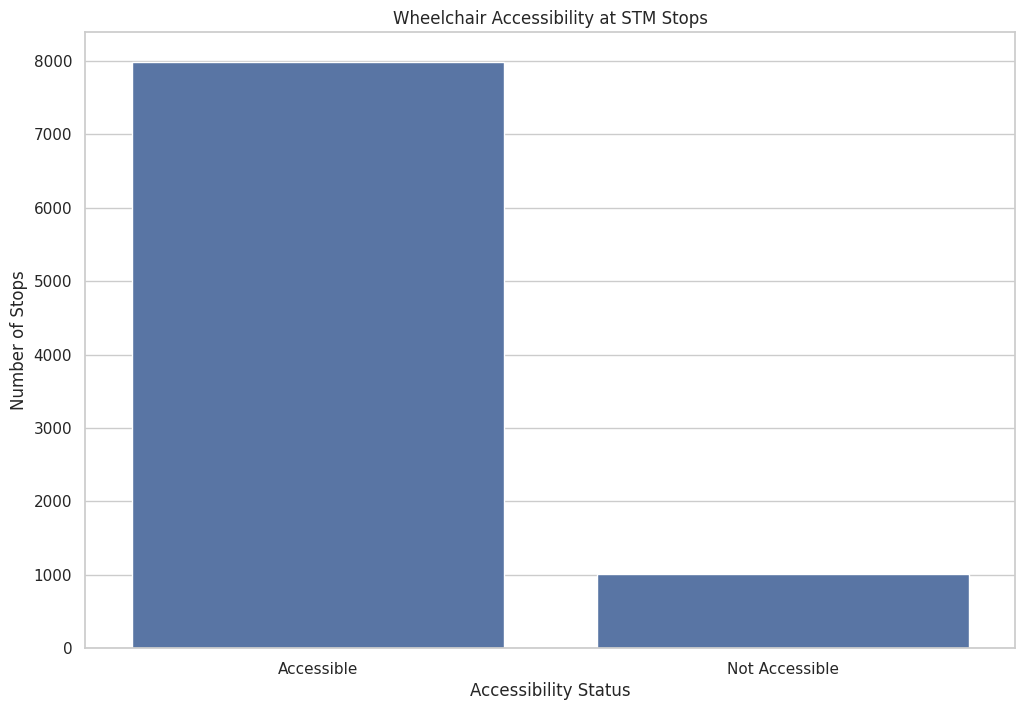

In [49]:
# count Wheelchair-Accessible Stops
accessible_stops = stops['wheelchair_boarding'].value_counts().reset_index()
accessible_stops.columns = ['wheelchair_boarding', 'count']

# map code to labels
accessible_stops['wheelchair_boarding'] = accessible_stops['wheelchair_boarding'].map({
    0: 'No Information',
    1: 'Accessible',
    2: 'Not Accessible'
})

# plot accessibility data
sns.barplot(x='wheelchair_boarding', y='count', data=accessible_stops)
plt.title('Wheelchair Accessibility at STM Stops')
plt.xlabel('Accessibility Status')
plt.ylabel('Number of Stops')
plt.show()

#### Question 3: How can we optimize schedules to better serve riders?
- Identify which time people take the transit often.

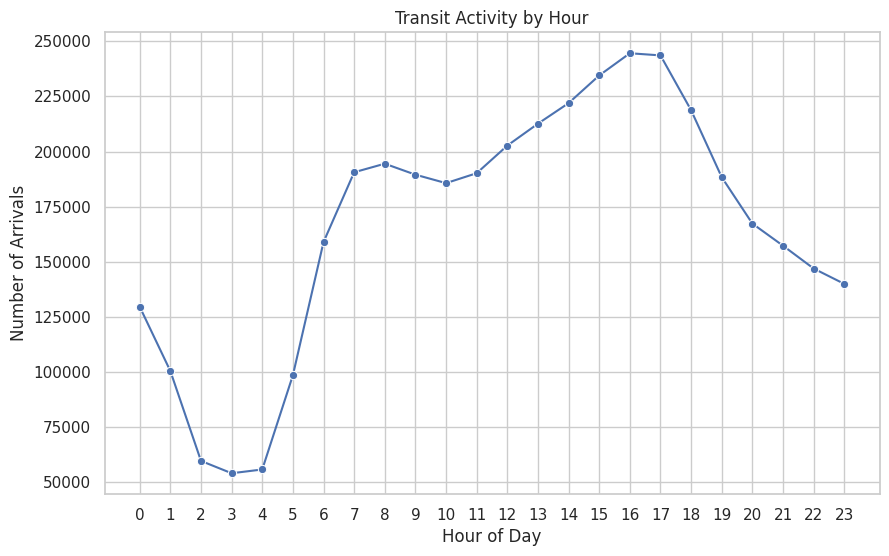

In [50]:
merged_df['hour'] = merged_df['arrival_time'].apply(lambda x: x.hour)
peak_hours = merged_df['hour'].value_counts().sort_index()

# peak hours visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x=peak_hours.index, y=peak_hours.values, marker='o')
plt.title('Transit Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Arrivals')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

#### To visualize bus stop activity in Montreal with darker colors representing busier stops, we can use a sequential colormap that transitions from light to dark shades of blue.

In [51]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# aggregate stop frequencies
stop_frequencies = stop_times['stop_id'].value_counts().reset_index()
stop_frequencies.columns = ['stop_id', 'frequency']

# merge with stops DataFrame to get lat/lon
stops = pd.merge(stops, stop_frequencies, on='stop_id', how='left')
stops['frequency'].fillna(0, inplace=True)  # fill NaNs with 0 for stops with no activity

# normalize frequency
max_freq = stops['frequency'].max()
min_freq = stops['frequency'].min()
stops['normalized_freq'] = (stops['frequency'] - min_freq) / (max_freq - min_freq)

<ipython-input-51-066b9ce9deb0>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stops['frequency'].fillna(0, inplace=True)  # fill NaNs with 0 for stops with no activity


In [52]:
import matplotlib.colors as mcolors
def get_color(frequency):
    colormap = plt.cm.Blues
    return colormap(frequency)

# create a Map Centered on Montreal
montreal_map = folium.Map(location=[45.5017, -73.5673], zoom_start=12)

# add Stops to the Map with Colors based on frequency
for idx, row in stops_with_freq.iterrows():
    color = get_color(row['normalized_freq'])
    color_hex = mcolors.rgb2hex(color[:3])
    folium.CircleMarker(
        location=[row['stop_lat'], row['stop_lon']],
        radius=1,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7
    ).add_to(montreal_map)

montreal_map

<img src="img/montreal map created.png" width=600 height=300/>

Our analysis indicates that Station Angrignon experiences the highest number of arrivals, as depicted by the darker blue shading on the map. This visualization effectively highlights the station's prominence in terms of passenger traffic.

## 4. Recommendations

1. **Increase Service Frequency on Low-Frequency Routes:** Routes with fewer trips may benefit from increased service to reduce wait times and improve rider satisfaction.
2. **Improve Accessibility:** Several stops are not wheelchair accessible. Prioritize upgrades to make transit more inclusive.

## 5. Conclusion
In this analysis, we employed Exploratory Data Analysis (EDA) techniques to uncover patterns in Montreal's transit data. By visualizing transit activity across different hours, we identified peak usage times and high-traffic days, providing valuable insights for optimizing transit operations.

Our analysis of Montreal's transit data reveals that weekday mornings between 3:00 PM and 4:00 PM are the busiest periods, with central stops such as Station Angrignon     and Station Henri-Bourassa experiencing the highest passenger arrivals. These insights can guide transit authorities in optimizing resource allocation, such as deploying additional buses or staff during peak times, to enhance passenger experience.

However, this analysis is based on data from a specific timeframe and does not account for seasonal variations or special events. Future studies should incorporate data from different seasons and consider passenger feedback to provide a more comprehensive understanding of transit patterns and areas needing improvement. Future analyses could incorporate additional variables or employ predictive modeling to enhance these insights further.

By analyzing STM’s GTFS data, we’ve uncovered actionable insights to improve Montreal’s public transit system. From increasing service frequency to improving accessibility, these changes can make transit more efficient, inclusive, and user-friendly.

As a transit enthusiast and data analyst, I’m excited about the opportunity to work with Transit to build a better future for urban mobility. Let’s make transit the best it can be! Thanks for making it this far! 😸